In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import os

# labour dataset

In [2]:
# working age population (thousand) by sex edu and place of birth
# 工作年龄人口
pop = pd.read_csv("../data/MST_XWAP_SEX_EDU_CBR_NB_A-filtered-2025-01-01.csv")

# labour force paritication rate (%) by sex edu and place of birth
# 劳动参与率 = 劳动参与人口 / 工作年龄人口
labour = pd.read_csv("../data/MST_TEAP_SEX_EDU_CBR_RT_A-filtered-2025-01-01.csv")

# employment to population ratio (%) by sex edu and place of birth
# 就业率 = 工作人口 / 工作年龄人口
emp = pd.read_csv("../data/MST_TEMP_SEX_EDU_CBR_RT_A-filtered-2025-01-01.csv")

# unemployment rate (%) by sex edu and place of birth
# 失业率 = 失业人口 / 劳动参与人口
unemp = pd.read_csv("../data/MST_TUNE_SEX_EDU_CBR_RT_A-filtered-2025-01-01.csv")

unemp.head()

,ref_area.label,source.label,indicator.label,sex.label,classif1.label,classif2.label,time,obs_value,obs_status.label,note_classif.label,note_indicator.label,note_source.label
0,Albania,LFS - Labour Force Survey,"Unemployment rate by sex, education and place ...",Sex: Total,Education (Aggregate levels): Total,Place of birth: Total,2023,10.669,NaN,NaN,NaN,Repository: ILO-STATISTICS - Micro data proces...
1,Albania,LFS - Labour Force Survey,"Unemployment rate by sex, education and place ...",Sex: Total,Education (Aggregate levels): Total,Place of birth: Native-born,2023,10.656,NaN,NaN,NaN,Repository: ILO-STATISTICS - Micro data proces...
2,Albania,LFS - Labour Force Survey,"Unemployment rate by sex, education and place ...",Sex: Total,Education (Aggregate levels): Total,Place of birth: Foreign-born,2023,14.281,Unreliable,NaN,NaN,Repository: ILO-STATISTICS - Micro data proces...
3,Albania,LFS - Labour Force Survey,"Unemployment rate by sex, education and place ...",Sex: Total,Education (Aggregate levels): Less than basic,Place of birth: Total,2023,7.960,NaN,NaN,NaN,Repository: ILO-STATISTICS - Micro data proces...
4,Albania,LFS - Labour Force Survey,"Unemployment rate by sex, education and place ...",Sex: Total,Education (Aggregate levels): Less than basic,Place of birth: Native-born,2023,7.960,NaN,NaN,NaN,Repository: ILO-STATISTICS - Micro data proces...


# labour dataset cleaning

In [3]:
def no_label(df):
    # Replace column names ending with ".label" with the prefix before ".label"
    new_columns = [col.split(".label")[0] if ".label" in col else col for col in df.columns]
    
    # Replace "classifn" with attribute names
    new_columns = ["education" if col == "classif1" else col for col in new_columns]
    new_columns = ["birthplace" if col == "classif2" else col for col in new_columns]
    new_columns = ["country" if col == "ref_area" else col for col in new_columns]
    new_columns = ["year" if col == "time" else col for col in new_columns]
    
    # Assign modified column names back to the DataFrame
    df.columns = new_columns
    
    return df

def no_prefix(df):
    # Delete unnecessary text in attribute columns
    if "sex" in df.columns:
        df["sex"] = df["sex"].str.replace("Sex: ", "", regex=False)
    if "education" in df.columns:
        df["education"] = df["education"].str.replace("Education (Aggregate levels): ", "", regex=False)
    if "birthplace" in df.columns:
            df["birthplace"] = df["birthplace"].str.replace("Place of birth: ", "", regex=False)
            df["birthplace"] = df["birthplace"].str.replace("-born", "", regex=False)
    return df

def data_cleaning(df):
    df = no_label(df)
    df = no_prefix(df)
    newdf = df[["country", "sex", "education", "birthplace", "year", "obs_value"]]
    return newdf

pop = data_cleaning(pop)
labour = data_cleaning(labour)
emp = data_cleaning(emp)
unemp = data_cleaning(unemp)

unemp.head()

,country,sex,education,birthplace,year,obs_value
0,Albania,Total,Total,Total,2023,10.669
1,Albania,Total,Total,Native,2023,10.656
2,Albania,Total,Total,Foreign,2023,14.281
3,Albania,Total,Less than basic,Total,2023,7.960
4,Albania,Total,Less than basic,Native,2023,7.960


# join 4 labour datasets

In [4]:
def join_labour_dataset(*datasets_and_names):
    # Rename the 'obs_value' column in each dataset and prepare for merging
    renamed_datasets = []
    for dataset, name in datasets_and_names:
        renamed_dataset = dataset.rename(columns={"obs_value": name})
        renamed_datasets.append(renamed_dataset)
    
    # Initialize the merged DataFrame with the first dataset
    merged = renamed_datasets[0]
    
    # Sequentially merge each dataset on the unique keys
    for df in renamed_datasets[1:]:
        merged = pd.merge(
            merged, 
            df, 
            on=["country", "sex", "education", "birthplace", "year"], 
            how="outer"  # Outer join to keep all data
        )
    
    return merged

# Join all datasets with renaming
merged_labour = join_labour_dataset(
    (pop, "workpopK"),  # working age population (thousand)
    (labour, "labourR"),  # labour force paritication rate (%)
    (emp, "employR"),  # employment to population ratio (%)
    (unemp, "unemployR"),  # unemployment rate (%)
    
)

merged_labour.head()

,country,sex,education,birthplace,year,workpopK,labourR,employR,unemployR
0,Albania,Total,Total,Total,2023,2320.454,63.882,57.066,10.669
1,Albania,Total,Total,Native,2023,2309.725,63.956,57.141,10.656
2,Albania,Total,Total,Foreign,2023,10.729,47.895,41.055,14.281
3,Albania,Total,Less than basic,Total,2023,39.487,23.465,21.597,7.960
4,Albania,Total,Less than basic,Native,2023,39.348,23.547,21.673,7.960


# earning dataset

In [5]:
# average monthly earnings $ by sex
earn_sex = pd.read_csv("../data/EAR_4MTH_SEX_CUR_NB_A-filtered-2025-01-11.csv")

# average monthly earnings $ by sex and education
earn_sexedu = pd.read_csv("../data/EAR_4MTH_SEX_EDU_CUR_NB_A-filtered-2025-01-11.csv")

# average monthly earnings $ by sex and place of birth
earn_sexbirp = pd.read_csv("../data/EAR_4MTH_SEX_CBR_CUR_NB_A-filtered-2025-01-11.csv")

earn_sexbirp.head()

,ref_area.label,source.label,indicator.label,sex.label,classif1.label,classif2.label,time,obs_value,obs_status.label,note_indicator.label,note_source.label
0,Belgium,LFS - EU Labour Force Survey,Average monthly earnings of employees by sex a...,Sex: Male,Place of birth: Native-born,Currency: U.S. dollars,2021,4291.644,NaN,Job coverage: Main job currently held | Curren...,NaN
1,Belgium,LFS - EU Labour Force Survey,Average monthly earnings of employees by sex a...,Sex: Male,Place of birth: Foreign-born,Currency: U.S. dollars,2021,3952.884,NaN,Job coverage: Main job currently held | Curren...,NaN
2,Belgium,LFS - EU Labour Force Survey,Average monthly earnings of employees by sex a...,Sex: Male,Place of birth: Status unknown,Currency: U.S. dollars,2021,2923.285,NaN,Job coverage: Main job currently held | Curren...,NaN
3,Belgium,LFS - EU Labour Force Survey,Average monthly earnings of employees by sex a...,Sex: Female,Place of birth: Native-born,Currency: U.S. dollars,2021,3428.989,NaN,Job coverage: Main job currently held | Curren...,NaN
4,Belgium,LFS - EU Labour Force Survey,Average monthly earnings of employees by sex a...,Sex: Female,Place of birth: Foreign-born,Currency: U.S. dollars,2021,3030.677,NaN,Job coverage: Main job currently held | Curren...,NaN


# earning dataset cleaning

In [6]:
# Clean and transform earn_sex
earn_sex.columns = [col.split(".label")[0] if ".label" in col else col for col in earn_sex.columns]
earn_sex.rename(columns={"ref_area": "country", "time": "year", "obs_value": "earning"}, inplace=True)
earn_sex["sex"] = earn_sex["sex"].str.replace("Sex: ", "", regex=False)
cleaned_earn_sex = earn_sex[["country", "sex", "year", "earning"]]

# Clean and transform earn_sexedu
earn_sexedu.columns = [col.split(".label")[0] if ".label" in col else col for col in earn_sexedu.columns]
earn_sexedu.rename(columns={"ref_area": "country", "time": "year", "classif1": "education", "obs_value": "earning"}, inplace=True)
earn_sexedu["sex"] = earn_sexedu["sex"].str.replace("Sex: ", "", regex=False)
earn_sexedu["education"] = earn_sexedu["education"].str.replace("Education (Aggregate levels): ", "", regex=False)
cleaned_earn_sexedu = earn_sexedu[["country", "sex", "education", "year", "earning"]]

# Clean and transform earn_sexbirp
earn_sexbirp.columns = [col.split(".label")[0] if ".label" in col else col for col in earn_sexbirp.columns]
earn_sexbirp.rename(columns={"ref_area": "country", "time": "year", "classif1": "birthplace", "obs_value": "earning"}, inplace=True)
earn_sexbirp["sex"] = earn_sexbirp["sex"].str.replace("Sex: ", "", regex=False)
earn_sexbirp["birthplace"] = earn_sexbirp["birthplace"].str.replace("Place of birth: ", "", regex=False)
earn_sexbirp["birthplace"] = earn_sexbirp["birthplace"].str.replace("-born", "", regex=False)
cleaned_earn_sexbirp = earn_sexbirp[["country", "sex", "birthplace", "year", "earning"]]

cleaned_earn_sex.head()

,country,sex,year,earning
0,Albania,Total,2022,547.568
1,Albania,Male,2022,564.155
2,Albania,Female,2022,529.124
3,Albania,Total,2021,552.463
4,Albania,Male,2021,564.268


# see if the country names match

In [7]:
# Extract unique country names and return them as a set
def extract_country_names(df, column_name):
    return set(df[column_name].dropna().unique())

# For the filtered_labour dataset
country_labour = set(merged_labour["country"].dropna().unique())

# For the earn dataset
country_earn_sex = set(cleaned_earn_sex["country"].dropna().unique())
country_earn_sexedu = set(cleaned_earn_sexedu["country"].dropna().unique())
country_earn_sexbirp = set(cleaned_earn_sexbirp["country"].dropna().unique())

def find_exact_matches(source_countries, target_countries):
    exact_matches = source_countries & target_countries
    mismatched_source = source_countries - exact_matches  # Items in source not in exact_matches
    mismatched_target = target_countries - exact_matches  # Items in target not in exact_matches

    print("Exact Matches:")
    print(exact_matches)

    print("Mismatched from Source:")
    print(mismatched_source)

    print("Mismatched from Target:")
    print(mismatched_target, "\n")

In [8]:
print("labour and earnings by sex")
find_exact_matches(country_labour, country_earn_sex)
print("labour and earnings by sex and education")
find_exact_matches(country_labour, country_earn_sexedu)
print("labour and earnings by sex and birthplace")
find_exact_matches(country_labour, country_earn_sexbirp)

labour and earnings by sex
Exact Matches:
{'Bosnia and Herzegovina', 'Greece', 'Estonia', 'Belgium', 'Germany', 'Denmark', 'Kosovo', 'Norway', 'Czechia', 'France', 'Ireland', 'Luxembourg', 'Croatia', 'Ukraine', 'Iceland', 'Sweden', 'Serbia', 'Austria', 'Albania', 'Latvia', 'Slovakia', 'Lithuania', 'Montenegro', 'Romania', 'Switzerland', 'Poland', 'Italy', 'North Macedonia', 'Hungary', 'Slovenia', 'Portugal', 'Bulgaria', 'United Kingdom of Great Britain and Northern Ireland', 'Netherlands', 'Malta', 'Spain', 'Finland'}
Mismatched from Source:
set()
Mismatched from Target:
{'San Marino', 'Russian Federation', 'Republic of Moldova'} 

labour and earnings by sex and education
Exact Matches:
{'Bosnia and Herzegovina', 'Greece', 'Estonia', 'Belgium', 'Germany', 'Denmark', 'Norway', 'Czechia', 'France', 'Ireland', 'Luxembourg', 'Croatia', 'Iceland', 'Sweden', 'Serbia', 'Austria', 'Latvia', 'Slovakia', 'Lithuania', 'Romania', 'Switzerland', 'Poland', 'Italy', 'Hungary', 'Slovenia', 'Portugal',

# merge labour and earning dataset

In [9]:
merged_labour["earning"] = np.nan

In [10]:
merged_labour.head()

,country,sex,education,birthplace,year,workpopK,labourR,employR,unemployR,earning
0,Albania,Total,Total,Total,2023,2320.454,63.882,57.066,10.669,NaN
1,Albania,Total,Total,Native,2023,2309.725,63.956,57.141,10.656,NaN
2,Albania,Total,Total,Foreign,2023,10.729,47.895,41.055,14.281,NaN
3,Albania,Total,Less than basic,Total,2023,39.487,23.465,21.597,7.960,NaN
4,Albania,Total,Less than basic,Native,2023,39.348,23.547,21.673,7.960,NaN


In [11]:
# Step 1: Select rows from merged_labour
filtered_df = merged_labour[(merged_labour["education"] == "Total") & (merged_labour["birthplace"] == "Total")]

# Step 2: Merge the filtered dataframe with earning dataset
merged_df = pd.merge(
    filtered_df,
    cleaned_earn_sex,
    on=["country", "year", "sex"],
    how="left",
    suffixes=("", "_new")  # Avoid column name conflict
)

# Step 3: Update the 'earning' column in the filtered dataframe with the merged values
filtered_df["earning"] = merged_df["earning_new"]

# Step 3: update the original merged_labour DataFrame with the new earning values
merged_labour.loc[filtered_df.index, "earning"] = filtered_df["earning"]

C:\Users\J4vix\AppData\Local\Temp\ipykernel_12256\2768683574.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["earning"] = merged_df["earning_new"]


In [12]:
# Step 1: Select rows from merged_labour
filtered_df = merged_labour[merged_labour["education"] == "Total"]

# Step 2: Merge the filtered dataframe with earning dataset
merged_df = pd.merge(
    filtered_df, 
    cleaned_earn_sexbirp,
    on=["country", "year", "sex", "birthplace"], 
    how="left",
    suffixes=("", "_new")  # Avoid column name conflict
)

# Step 3: Update the 'earning' column in the filtered dataframe with the merged values
filtered_df["earning"] = merged_df["earning_new"]

# Step 3: update the original merged_labour DataFrame with the new earning values
merged_labour.loc[filtered_df.index, "earning"] = filtered_df["earning"]

C:\Users\J4vix\AppData\Local\Temp\ipykernel_12256\3221258290.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["earning"] = merged_df["earning_new"]


In [13]:
# Step 1: Select rows from merged_labour
filtered_df = merged_labour[merged_labour["birthplace"] == "Total"]

# Step 2: Merge the filtered dataframe with earning dataset
merged_df = pd.merge(
    filtered_df, 
    cleaned_earn_sexedu,
    on=["country", "year", "sex", "education"], 
    how="left",
    suffixes=("", "_new")  # Avoid column name conflict
)

# Step 3: Update the 'earning' column in the filtered dataframe with the merged values
filtered_df["earning"] = merged_df["earning_new"]

# Step 3: update the original merged_labour DataFrame with the new earning values
merged_labour.loc[filtered_df.index, "earning"] = filtered_df["earning"]

C:\Users\J4vix\AppData\Local\Temp\ipykernel_12256\727138686.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["earning"] = merged_df["earning_new"]


In [14]:
merged_labour[100:200:5]

,country,sex,education,birthplace,year,workpopK,labourR,employR,unemployR,earning
100,Albania,Female,Level not stated,Total,2022,0.931,NaN,NaN,NaN,NaN
105,Albania,Total,Less than basic,Total,2021,45.967,23.442,15.744,32.838,NaN
110,Albania,Total,Basic,Foreign,2021,3.624,18.447,18.447,NaN,NaN
115,Albania,Total,Advanced,Native,2021,420.344,76.025,68.123,10.394,NaN
120,Albania,Male,Less than basic,Total,2021,19.237,27.353,21.676,20.754,NaN
125,Albania,Male,Basic,Foreign,2021,1.915,33.768,33.768,NaN,NaN
130,Albania,Male,Advanced,Native,2021,184.277,78.488,71.705,8.642,NaN
135,Albania,Female,Less than basic,Total,2021,26.730,20.628,11.476,44.370,NaN
140,Albania,Female,Basic,Foreign,2021,1.709,NaN,NaN,NaN,NaN
145,Albania,Female,Advanced,Native,2021,236.067,74.102,65.327,11.842,NaN


# map dataset

In [15]:
import json

# Load the JSON file
file_path = '../data/europe.geo.json'
with open(file_path, 'r', encoding='utf-8') as f:
    geojson_data = json.load(f)

# Extract country names
def extract_country_names_map(geojson_data):
    country_names = set()
    for feature in geojson_data['features']:
        if 'properties' in feature and 'name' in feature['properties']:
            country_names.add(feature['properties']['name'])
    return country_names

# Get the country names from map
country_map = extract_country_names_map(geojson_data)

In [16]:
find_exact_matches(country_labour, country_map)
# mismatch for BH and UK

Exact Matches:
{'Greece', 'Estonia', 'Belgium', 'Germany', 'Denmark', 'Kosovo', 'Norway', 'Czechia', 'France', 'Ireland', 'Luxembourg', 'Croatia', 'Ukraine', 'Iceland', 'Sweden', 'Serbia', 'Austria', 'Albania', 'Latvia', 'Slovakia', 'Lithuania', 'Montenegro', 'Romania', 'Switzerland', 'Poland', 'Italy', 'North Macedonia', 'Hungary', 'Slovenia', 'Portugal', 'Bulgaria', 'Netherlands', 'Malta', 'Spain', 'Finland'}
Mismatched from Source:
{'Bosnia and Herzegovina', 'United Kingdom of Great Britain and Northern Ireland'}
Mismatched from Target:
{'Andorra', 'Liechtenstein', 'Guernsey', 'Russia', 'United Kingdom', 'Faeroe Is.', 'Jersey', 'Åland', 'Vatican', 'Belarus', 'Bosnia and Herz.', 'San Marino', 'Monaco', 'Moldova', 'Isle of Man'} 



In [17]:
# rename the labour dataset
merged_labour['country'] = merged_labour['country'].replace({
    'Bosnia and Herzegovina': 'Bosnia and Herz.',
    'United Kingdom of Great Britain and Northern Ireland': 'United Kingdom'
})

# basic visuals

In [18]:
merged_labour.head()

,country,sex,education,birthplace,year,workpopK,labourR,employR,unemployR,earning
0,Albania,Total,Total,Total,2023,2320.454,63.882,57.066,10.669,NaN
1,Albania,Total,Total,Native,2023,2309.725,63.956,57.141,10.656,NaN
2,Albania,Total,Total,Foreign,2023,10.729,47.895,41.055,14.281,NaN
3,Albania,Total,Less than basic,Total,2023,39.487,23.465,21.597,7.960,NaN
4,Albania,Total,Less than basic,Native,2023,39.348,23.547,21.673,7.960,NaN


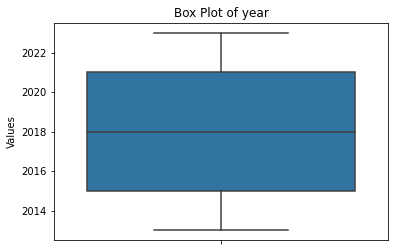

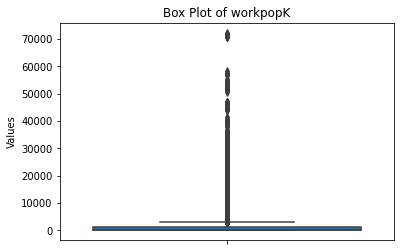

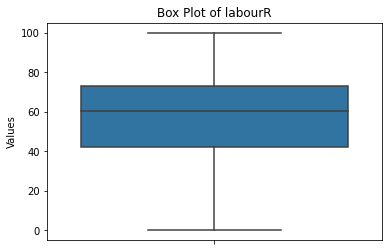

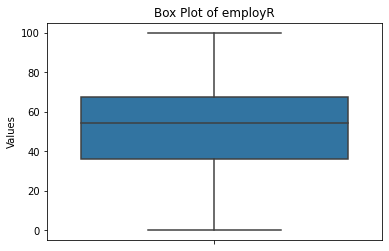

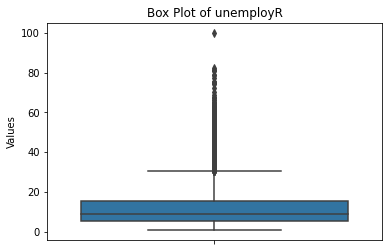

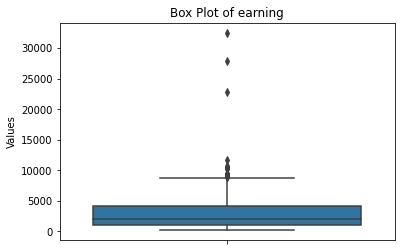

In [19]:
numeric_columns = merged_labour.columns[-6:]

for col in numeric_columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(y=merged_labour[col])
    plt.title(f"Box Plot of {col}")
    plt.ylabel("Values")
    plt.grid(False)
    plt.show()

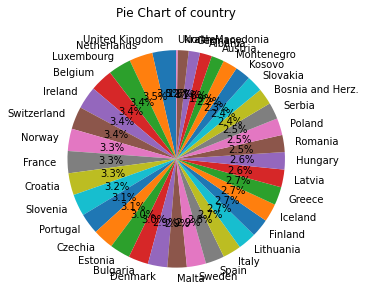

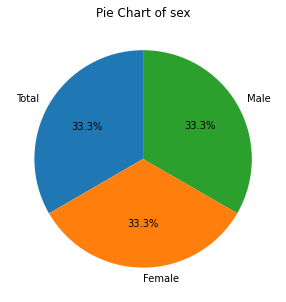

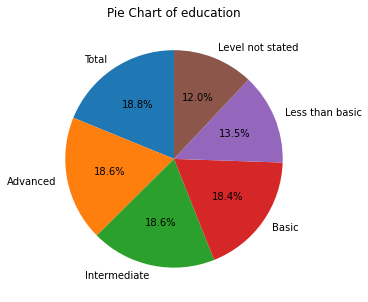

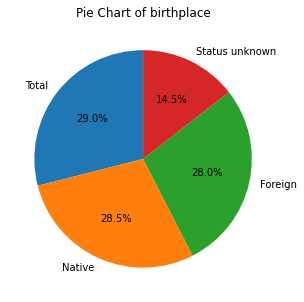

In [20]:
def draw_pie_chart(df, column_name):
    counts = df[column_name].value_counts()  # Count occurrences of each category
    plt.figure(figsize=(6, 5), facecolor='white')  # Set figure background to white
    plt.gca().set_facecolor('white')  # Set axes background to white
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)
    plt.title(f"Pie Chart of {column_name}")
    plt.show()

draw_pie_chart(merged_labour, "country")
draw_pie_chart(merged_labour, "sex")
draw_pie_chart(merged_labour, "education")
draw_pie_chart(merged_labour, "birthplace")

### Write Results to Database

Open the database

In [21]:
connection = sqlite3.connect("data.db")

Write to database 

In [22]:
data_tdb = merged_labour
data_tdb.to_sql("labour", con=connection, if_exists='replace', index_label='id')

Close database connection

In [23]:
connection.close()